# Connect to dataset

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import os
import cv2 as cv
import random

In [23]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [24]:
def random_load_image_from_directory(directory, num_images=10):
  images = []
  for filename in os.listdir(directory):
    img = cv.imread(os.path.join(directory, filename))
    images.append(img)

  return random.sample(images, min(num_images, len(images)))

In [25]:
random_bacterial_blight = random_load_image_from_directory("/content/drive/MyDrive/Research Leaf/ASHIIQ/Train/ASHIQ_Train_Bacterial_Leaf_Blight")
bacterial_blight = load_images_from_folder("/content/drive/MyDrive/Research Leaf/ASHIIQ/Train/ASHIQ_Train_Bacterial_Leaf_Blight")

# K mean segmentation






In [26]:
import matplotlib.pyplot as plt
import numpy as np

In [27]:
def k_mean_segmentation(disease, attempts=10, K=2):
  leaf_image = disease.reshape((-1,3))
  leaf_image = np.float32(leaf_image)

  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  ret, labels, centers = cv.kmeans(leaf_image, K, None, criteria, attempts, cv.KMEANS_PP_CENTERS)

  centers = np.uint8(centers)
  segmented_image = centers[labels.flatten()]
  segmented_image = segmented_image.reshape((disease.shape))

  return segmented_image, labels, centers

In [28]:
def mask_filter(image, segmented_image, cluster, labels):
  mask = (labels.flatten() == cluster)
  filtered_image = np.zeros_like(segmented_image)
  filtered_image[mask.reshape(image.shape[:2])] = segmented_image[mask.reshape(image.shape[:2])]
  return filtered_image

In [39]:
test_K = 7
test_image = cv.imread("/content/drive/MyDrive/Research Leaf/ASHIIQ/Train/ASHIQ_Train_Bacterial_Leaf_Blight/11.JPG")
test_image = cv.cvtColor(test_image, cv.COLOR_BGR2RGB)
segmented_test_image, test_labels, test_center = k_mean_segmentation(test_image, K=test_K)

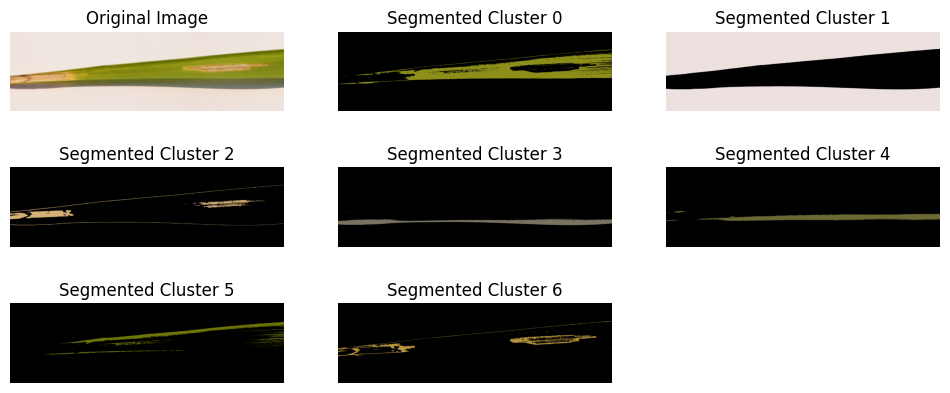

In [40]:
plt.figure(figsize=(12, 5))
plt.subplot(3, 3, 1)
plt.title("Original Image")
plt.imshow(test_image)
plt.axis("off")

for cluster in range(test_K):
  filtered_test_image = mask_filter(test_image, segmented_test_image, cluster, test_labels)

  plt.subplot(3, 3, cluster + 2)
  plt.title(f'Segmented Cluster {cluster}')
  plt.imshow(filtered_test_image)
  plt.axis("off")

plt.show()

# Calculate optimal cluster
## Using Elbow Wcss
## using Gap statistic

### EW for 1 image

In [30]:
from sklearn.cluster import KMeans

In [12]:
def calculate_wcss(image, max_k=10):
    wcss = []
    pixel_values = image.reshape((-1, 3))
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixel_values)
        wcss.append(kmeans.inertia_)
    return wcss

In [13]:
wcss = calculate_wcss(test_image, max_k=10)

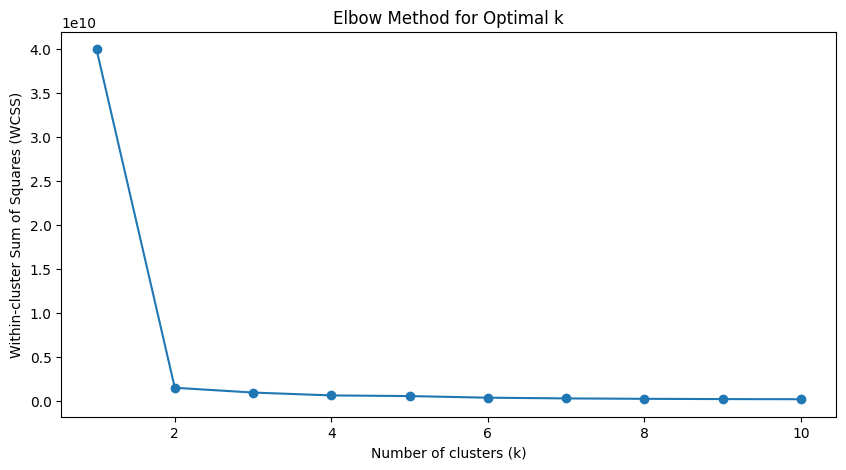

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.show()

### EW for multi image

In [15]:
def calculate_multi_image_wcss(images, max_k=10):
    wcss = []
    pixel_values = np.vstack([img.reshape((-1, 3)) for img in images])
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixel_values)
        wcss.append(kmeans.inertia_)
    return wcss

In [16]:
wcss = calculate_multi_image_wcss(random_bacterial_blight, max_k=10)


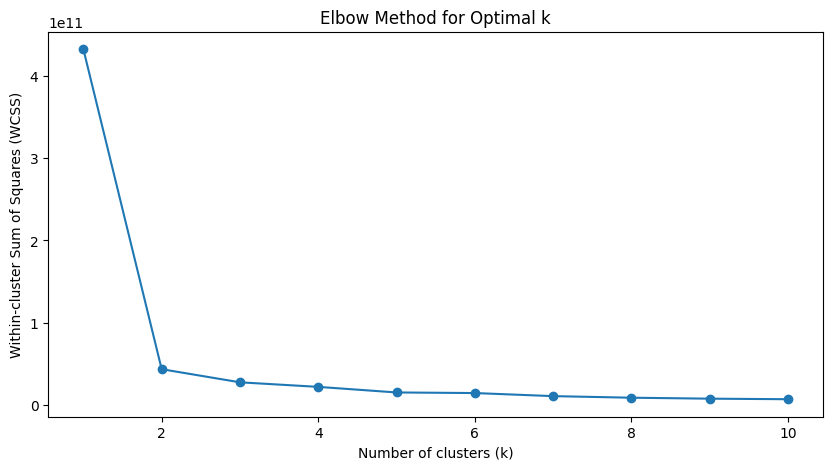

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.show()

### Gap statistic

In [31]:
from sklearn.metrics import pairwise_distances

In [41]:
def calculate_gap_statistic(image, max_k=10, n_refs=10):
    pixel_values = image.reshape((-1, 3))
    gaps = np.zeros(max_k)
    s_k = np.zeros(max_k)
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixel_values)
        disp = np.mean(np.min(pairwise_distances(pixel_values, kmeans.cluster_centers_, metric='euclidean'), axis=1))

        ref_disps = np.zeros(n_refs)
        for i in range(n_refs):
            random_reference = np.random.random_sample(size=pixel_values.shape)
            kmeans.fit(random_reference)
            ref_disp = np.mean(np.min(pairwise_distances(random_reference, kmeans.cluster_centers_, metric='euclidean'), axis=1))
            ref_disps[i] = ref_disp

        gap = np.log(np.mean(ref_disps)) - np.log(disp)
        gaps[k-1] = gap
        s_k[k-1] = np.sqrt(np.mean((np.log(ref_disps) - np.log(disp))**2))

    return gaps, s_k

In [44]:
gaps, s_k = calculate_gap_statistic(test_image, max_k=8, n_refs=8)

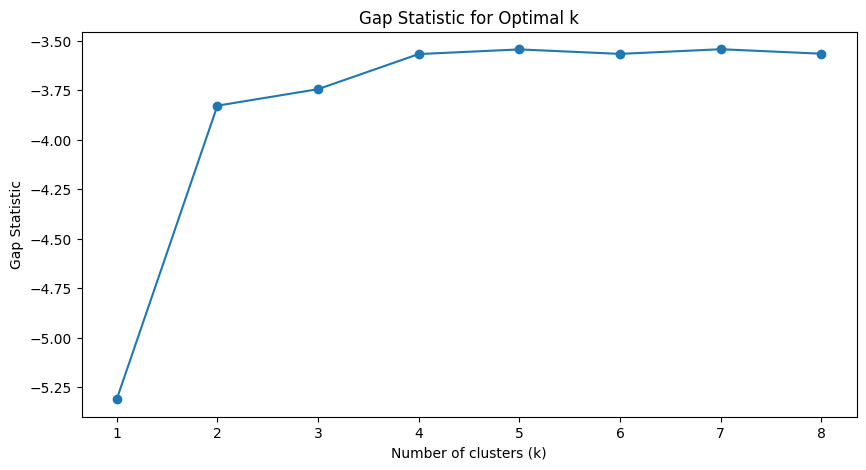

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 9), gaps, marker='o')
plt.title('Gap Statistic for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Gap Statistic')
plt.show()

In [48]:
optimal_k = np.argmax(gaps) + 1
print(f'The optimal number of clusters is: {optimal_k}')

The optimal number of clusters is: 7


In [42]:
def multi_calculate_gap_statistic(images, max_k=10, n_refs=10):
    pixel_values = np.vstack([img.reshape((-1, 3)) for img in images])
    gaps = np.zeros(max_k)
    s_k = np.zeros(max_k)
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixel_values)
        disp = np.mean(np.min(pairwise_distances(pixel_values, kmeans.cluster_centers_, metric='euclidean'), axis=1))

        ref_disps = np.zeros(n_refs)
        for i in range(n_refs):
            random_reference = np.random.random_sample(size=pixel_values.shape)
            kmeans.fit(random_reference)
            ref_disp = np.mean(np.min(pairwise_distances(random_reference, kmeans.cluster_centers_, metric='euclidean'), axis=1))
            ref_disps[i] = ref_disp

        gap = np.log(np.mean(ref_disps)) - np.log(disp)
        gaps[k-1] = gap
        s_k[k-1] = np.sqrt(np.mean((np.log(ref_disps) - np.log(disp))**2))

    return gaps, s_k

In [33]:
gaps, s_k = calculate_gap_statistic(random_bacterial_blight, max_k=8)

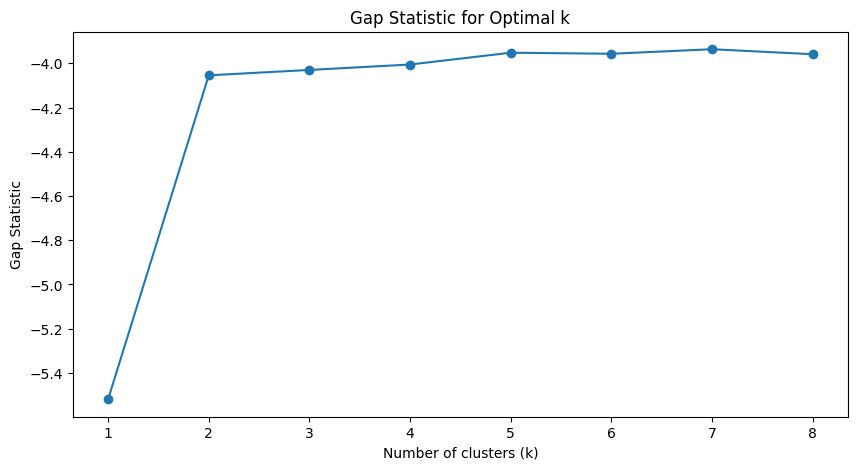

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 9), gaps, marker='o')
plt.title('Gap Statistic for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Gap Statistic')
plt.show()

In [35]:
optimal_k = np.argmax(gaps) + 1
print(f'The optimal number of clusters is: {optimal_k}')

The optimal number of clusters is: 7
